### TF-IDF Vectorizer for EDA

In [3]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
df = pd.read_parquet('../data/2.cryptonews_processed.parquet')

# Combine title and text for feature extraction
df['combined_text'] = df['title'] + ' ' + df['text']

print(df.shape)
df.head()

(155376, 5)


,title,text,source_name,date,combined_text
0,2021 Bitcoin Price Predictions: Is The Massive...,As the bitcoin price hovers under the psycholo...,Forbes,2021-01-02 00:20:00+00:00,2021 Bitcoin Price Predictions: Is The Massive...
1,Will Central Banks Hold Bitcoin in 2021?,Central banks (CB) will hold bitcoin sooner or...,BeInCrypto,2021-01-01 20:31:35+00:00,Will Central Banks Hold Bitcoin in 2021? Centr...
2,"Bitcoin Is Digital Social Justice, feat. Tyron...",The podcaster and CEO of Onramp Invest discuss...,Coindesk,2021-01-01 19:15:02+00:00,"Bitcoin Is Digital Social Justice, feat. Tyron..."
3,Bitcoin hits all-time high against gold as hav...,"BTC has hit another milestone, this time again...",Cointelegraph,2021-01-01 18:52:00+00:00,Bitcoin hits all-time high against gold as hav...
4,"The Last Time This Indicator Flashed, Bitcoin ...",Bitcoin has been facing some turbulence as of ...,Bitcoinist,2021-01-01 18:00:00+00:00,"The Last Time This Indicator Flashed, Bitcoin ..."


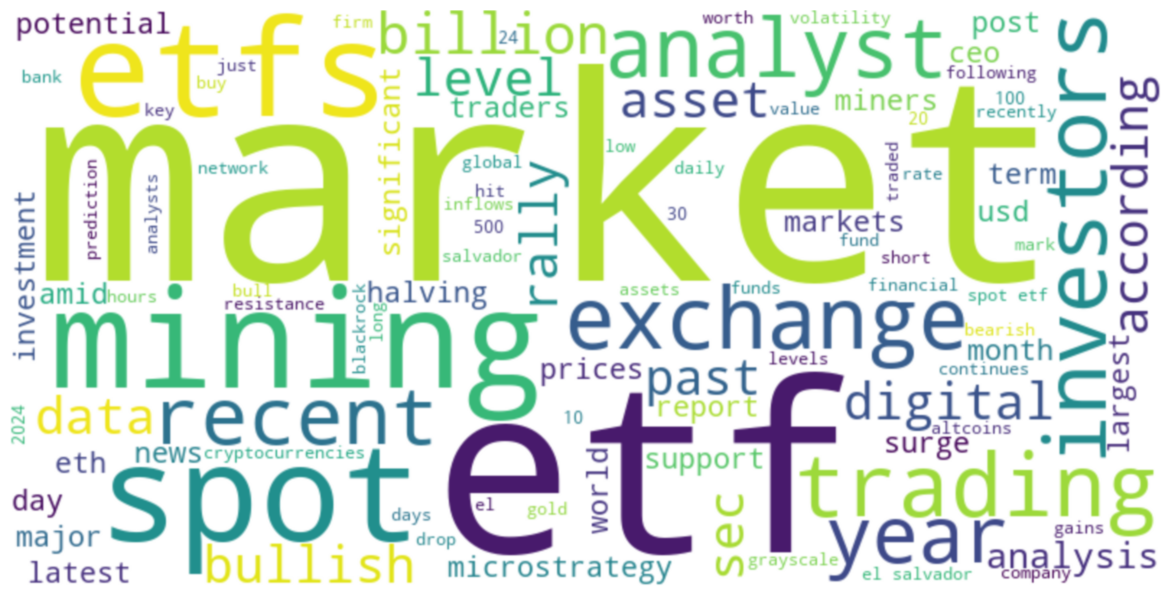

In [ ]:
# remove common words
custom_stopwords = set(TfidfVectorizer(stop_words='english').get_stop_words())
custom_stopwords.update(['bitcoin', 'btc', 'crypto', '000', 'price', 'new', 'cryptocurrency', 'ethereum', 'million', 'time', 'high', 'week', 'despite',
                         'says', "using", "used", "use", "based", "going", "come", "want", "need", 'today'])

# td-idf with n-grams
tfidf = TfidfVectorizer(max_features=25000, stop_words=list(custom_stopwords), ngram_range=(1, 3))
tfidf_matrix = tfidf.fit_transform(df['combined_text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

# Calculate average TF-IDF score for each feature
average_tfidf = tfidf_df.mean().sort_values(ascending=False)

# Get the top features
top_features = average_tfidf.head(100)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_features.to_dict())

# Display word cloud
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='lanczos')
plt.axis('off')
plt.show()

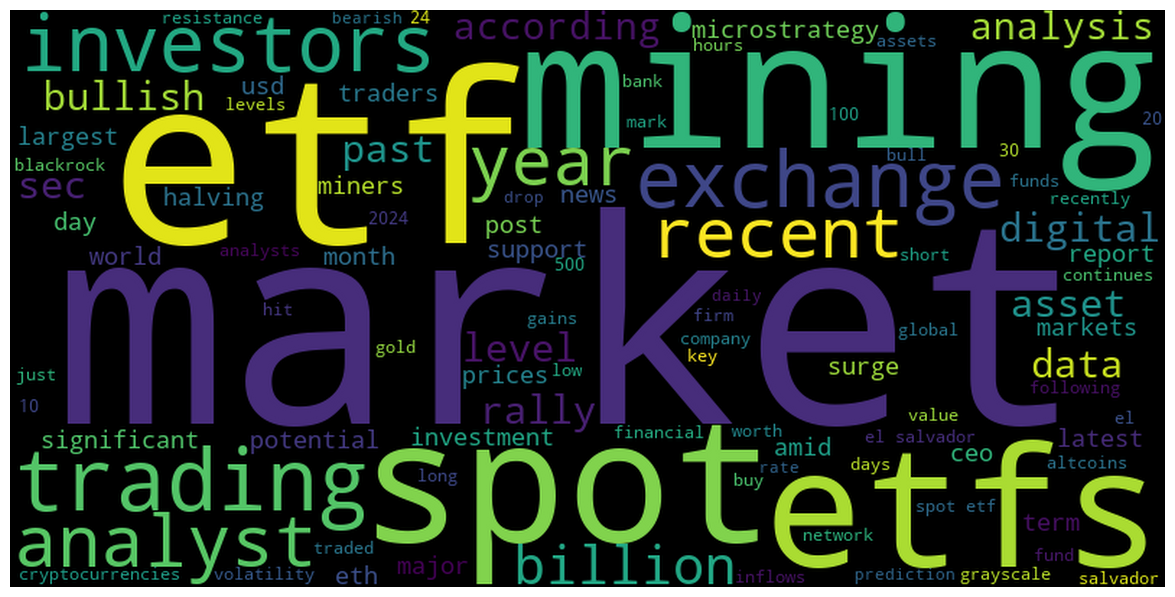

In [30]:
# regenerate word cloud with black background and viridis colormap

wordcloud = WordCloud(
  width=800,
  height=400,
  background_color='black',
  colormap='viridis',
  prefer_horizontal=1, 
).generate_from_frequencies(top_features.to_dict())

# Display word cloud
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='lanczos')
plt.axis('off')
plt.show()

### BERTopic

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import torch
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired
import nltk

In [2]:
df = pd.read_parquet('../data/2.cryptonews_processed.parquet')
print(df.shape)
df.head()

(155376, 4)


,title,text,source_name,date
0,2021 Bitcoin Price Predictions: Is The Massive...,As the bitcoin price hovers under the psycholo...,Forbes,2021-01-02 00:20:00+00:00
1,Will Central Banks Hold Bitcoin in 2021?,Central banks (CB) will hold bitcoin sooner or...,BeInCrypto,2021-01-01 20:31:35+00:00
2,"Bitcoin Is Digital Social Justice, feat. Tyron...",The podcaster and CEO of Onramp Invest discuss...,Coindesk,2021-01-01 19:15:02+00:00
3,Bitcoin hits all-time high against gold as hav...,"BTC has hit another milestone, this time again...",Cointelegraph,2021-01-01 18:52:00+00:00
4,"The Last Time This Indicator Flashed, Bitcoin ...",Bitcoin has been facing some turbulence as of ...,Bitcoinist,2021-01-01 18:00:00+00:00


In [3]:
# Combine title and text for feature extraction
df['combined_text'] = df['title'] + ' ' + df['text']
df.drop(columns=['title', 'text'], inplace=True)
df.head()

,source_name,date,combined_text
0,Forbes,2021-01-02 00:20:00+00:00,2021 Bitcoin Price Predictions: Is The Massive...
1,BeInCrypto,2021-01-01 20:31:35+00:00,Will Central Banks Hold Bitcoin in 2021? Centr...
2,Coindesk,2021-01-01 19:15:02+00:00,"Bitcoin Is Digital Social Justice, feat. Tyron..."
3,Cointelegraph,2021-01-01 18:52:00+00:00,Bitcoin hits all-time high against gold as hav...
4,Bitcoinist,2021-01-01 18:00:00+00:00,"The Last Time This Indicator Flashed, Bitcoin ..."


In [4]:
# bertopic model

# remove stop words in topic representation
stop_words_list = nltk.corpus.stopwords.words("english")
stop_words_list.extend([
  # Cryptocurrencies
  "bitcoin", "bitcoins", "btc",
  "cryptocurrency", "cryptocurrencies", "crypto", "currency", "currencies",
  "ethereum", "eth", "xrp", "ripple", "dogecoin", "doge", "litecoin", "ltc", "bnb",
  "coin", "coins", "token", "tokens", "blockchain", "blockchains", "altcoin", "altcoins",
  
  # Common news words
  "breaking", "news", "today", "says", "told", "according", "reports",
  "could", "may", "might", "would", "said", "announced", "reported",
  
  # Time-related
  "day", "week", "month", "year", "hours", "minutes", "daily", "weekly",
  
  # Common verbs
  "using", "used", "use", "based", "going", "come", "want", "need",
])

topic_model = BERTopic(
  embedding_model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2"),
  umap_model = UMAP(n_neighbors=100, n_components=5, min_dist=0.1, metric='cosine', random_state=42, n_jobs=-1),
  hdbscan_model = HDBSCAN(min_cluster_size=1000, min_samples=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True, alpha=0.4, cluster_selection_epsilon=0.05),
  vectorizer_model = CountVectorizer(stop_words=stop_words_list, min_df=0.001, max_df=0.95, max_features=15000, ngram_range=(1, 3)),
  ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True),
  representation_model=KeyBERTInspired(),
  nr_topics="auto",
  calculate_probabilities=True,
  verbose=True,
  low_memory=False
)

# Fit the model
topics, probabilities = topic_model.fit_transform(df['combined_text'])

2025-01-26 12:46:32,030 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/4856 [00:00<?, ?it/s]

2025-01-26 12:52:34,545 - BERTopic - Embedding - Completed ✓
2025-01-26 12:52:34,546 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-01-26 12:59:48,767 - BERTopic - Dimensionality - Completed ✓
2025-01-26 12:59:48,775 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-01-26 13:00:22,354 - BERTopic - Cluster - Completed ✓
2025-01-26 13:00:22,355 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-01-26 13:00:49,448 - BERTopic - Representation - Completed ✓
2025-01-26 13:00:49,454 - BERTopic - Topic reduction - Reducing number of topics
2025-01-26 13:01:14,870 - BERTopic - Topic reduction - Reduced number of topics from 26 to 20


In [5]:
# Get topic information
topic_info = topic_model.get_topic_info()
topic_info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,82746,-1_mt gox_finance_price analysis_investors,"[mt gox, finance, price analysis, investors, m...","[Bitcoin could possibly go ‘as low as $20,000'..."
1,0,14817,0_etf approval_spot etf approval_blackrock etf...,"[etf approval, spot etf approval, blackrock et...",[Grayscale Dumps $2.14 Billion in Bitcoin (BTC...
2,1,11023,1_bull market_evening global market_cryptoquan...,"[bull market, evening global market, cryptoqua...","[Bitcoin, Ethereum Wobble As Election Results ..."
3,2,5057,2_lightning network_lightning labs_lightning_l...,"[lightning network, lightning labs, lightning,...",[Strike Announces Integration With Shopify to ...
4,3,4179,3_el salvador buys_el salvador president_presi...,"[el salvador buys, el salvador president, pres...",[Two More Countries Will Adopt Bitcoin as Lega...
5,4,3896,4_microstrategy ceo michael_microstrategy ceo_...,"[microstrategy ceo michael, microstrategy ceo,...",[Michael Saylor: ‘Bitcoin Must Be Understood A...
6,5,3517,5_price analysis bullish_price analysis_price ...,"[price analysis bullish, price analysis, price...",[Bitcoin price analysis: BTC looks to break hi...
7,6,3398,6_whale transactions_whale wallets_whales buyi...,"[whale transactions, whale wallets, whales buy...","[Ancient Bitcoin Whale Awakens, Abruptly Moves..."
8,7,3265,7_traders liquidated_liquidated price_price fe...,"[traders liquidated, liquidated price, price f...",[Bitcoin Plummets Below $58K as Crypto Market ...
9,8,3119,8_senator cynthia lummis_senator lummis_senato...,"[senator cynthia lummis, senator lummis, senat...",[US Senator Lummis Backs Bitcoin as National R...


In [6]:
# Function to analyze cluster sizes and outlier ratio
def analyze_clustering_results(topics, topic_info):
  total_docs = len(topics)
  outliers = len([t for t in topics if t == -1])
  outlier_percentage = (outliers / total_docs) * 100
  
  print(f"\nClustering Analysis:")
  print(f"Total documents: {total_docs}")
  print(f"Number of clusters: {len(topic_info[topic_info['Topic'] != -1])}")
  print(f"Outliers (Topic -1): {outliers}")
  print(f"Outlier percentage: {outlier_percentage:.2f}%")
  
  # Cluster size analysis
  cluster_sizes = topic_info[topic_info['Topic'] != -1]['Count']
  print("\nCluster Size Statistics:")
  print(f"Mean cluster size: {cluster_sizes.mean():.0f}")
  print(f"Median cluster size: {cluster_sizes.median():.0f}")
  print(f"Min cluster size: {cluster_sizes.min()}")
  print(f"Max cluster size: {cluster_sizes.max()}")
  
  return outlier_percentage, cluster_sizes

# Analyze clustering results
outlier_percentage, cluster_sizes = analyze_clustering_results(topics, topic_info)


Clustering Analysis:
Total documents: 155376
Number of clusters: 19
Outliers (Topic -1): 82746
Outlier percentage: 53.26%

Cluster Size Statistics:
Mean cluster size: 3823
Median cluster size: 2949
Min cluster size: 1150
Max cluster size: 14817


In [7]:
topic_model.visualize_hierarchy()

In [8]:
df['date'] = pd.to_datetime(df['date'])
timestamps = df['date'].tolist()

topics_over_time = topic_model.topics_over_time(
  docs=df['combined_text'],
  timestamps=timestamps,
  global_tuning=True,
  evolution_tuning=True,
  nr_bins=50
)

fig = topic_model.visualize_topics_over_time(
  topics_over_time,
  top_n_topics=10,  # Show top 10 topics
  normalize_frequency=True,
  width=1200,
  height=600
)
fig.show()

50it [01:21,  1.63s/it]


In [51]:
# topic_model.save("6.saved_bertopic_model", save_embedding_model=False)

2025-01-12 11:41:10,663 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


### BERTopic 2

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import torch
from bertopic import BERTopic
import nltk
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
df = pd.read_parquet('../data/2.cryptonews_processed.parquet')
print(df.shape)
df.head()

(155376, 4)


,title,text,source_name,date
0,2021 Bitcoin Price Predictions: Is The Massive...,As the bitcoin price hovers under the psycholo...,Forbes,2021-01-02 00:20:00+00:00
1,Will Central Banks Hold Bitcoin in 2021?,Central banks (CB) will hold bitcoin sooner or...,BeInCrypto,2021-01-01 20:31:35+00:00
2,"Bitcoin Is Digital Social Justice, feat. Tyron...",The podcaster and CEO of Onramp Invest discuss...,Coindesk,2021-01-01 19:15:02+00:00
3,Bitcoin hits all-time high against gold as hav...,"BTC has hit another milestone, this time again...",Cointelegraph,2021-01-01 18:52:00+00:00
4,"The Last Time This Indicator Flashed, Bitcoin ...",Bitcoin has been facing some turbulence as of ...,Bitcoinist,2021-01-01 18:00:00+00:00


In [3]:
# Combine title and text for feature extraction
df['combined_text'] = df['title'] + ' ' + df['text']
df.drop(columns=['title', 'text'], inplace=True)
df.head()

,source_name,date,combined_text
0,Forbes,2021-01-02 00:20:00+00:00,2021 Bitcoin Price Predictions: Is The Massive...
1,BeInCrypto,2021-01-01 20:31:35+00:00,Will Central Banks Hold Bitcoin in 2021? Centr...
2,Coindesk,2021-01-01 19:15:02+00:00,"Bitcoin Is Digital Social Justice, feat. Tyron..."
3,Cointelegraph,2021-01-01 18:52:00+00:00,Bitcoin hits all-time high against gold as hav...
4,Bitcoinist,2021-01-01 18:00:00+00:00,"The Last Time This Indicator Flashed, Bitcoin ..."


In [4]:
stop_words_list = nltk.corpus.stopwords.words("english")
stop_words_list.extend([
  # Cryptocurrencies
  "bitcoin", "bitcoins", "btc",
  "cryptocurrency", "cryptocurrencies", "crypto", "currency", "currencies",
  "ethereum", "eth", "xrp", "ripple", "dogecoin", "doge", "litecoin", "ltc", "bnb",
  "coin", "coins", "token", "tokens", "blockchain", "blockchains", "altcoin", "altcoins",
  
  # Common news words
  "breaking", "news", "today", "says", "told", "according", "reports",
  "could", "may", "might", "would", "said", "announced", "reported",
  
  # Time-related
  "day", "week", "month", "year", "hours", "minutes", "daily", "weekly",
  
  # Common verbs
  "using", "used", "use", "based", "going", "come", "want", "need",
])

zeroshot_topic_list = [
  "whale activity, large transaction", "market sentiment", "liquidity, volatility, price action, price movement, trading",
  "exchange traded funds, ETF", "institutional investments", "treasury, reserve", "stablecoin, CBDC",
  "government policy", "legal proceedings", "licensing approval", "privacy regulations", "enforcement actions", "tax regulations",
  "mining technology, mining difficulty, halving", "consensus updates", "security protocols", "quantum developments", "technical infrastructure",
  "nft, metaverse, virtual world", "social platforms", "sustainability, renewable, environmental", "interest rates, economic outlook",
  "product launches", "corporate partnerships"
]

topic_model = BERTopic(
  embedding_model="sentence-transformers/all-mpnet-base-v2",
  # min_topic_size=15,
  zeroshot_topic_list=zeroshot_topic_list,
  # zeroshot_min_similarity=.5,
  vectorizer_model = CountVectorizer(stop_words=stop_words_list, min_df=0.001, max_df=0.95, max_features=15000, ngram_range=(1, 3)),
  # representation_model=KeyBERTInspired(),
  verbose=True
)

# Fit the model
topics, probabilities = topic_model.fit_transform(df['combined_text'])

2025-01-26 13:40:05,623 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/4856 [00:00<?, ?it/s]

2025-01-26 13:46:01,296 - BERTopic - Embedding - Completed ✓
2025-01-26 13:46:01,297 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-01-26 13:47:19,083 - BERTopic - Dimensionality - Completed ✓
2025-01-26 13:47:19,091 - BERTopic - Zeroshot Step 1 - Finding documents that could be assigned to either one of the zero-shot topics
2025-01-26 13:47:19,782 - BERTopic - Zeroshot Step 1 - Completed ✓
2025-01-26 13:48:23,064 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-01-26 13:48:31,633 - BERTopic - Cluster - Completed ✓
2025-01-26 13:48:31,633 - BERTopic - Zeroshot Step 2 - Combining topics from zero-shot topic modeling with topics from clustering...
2025-01-26 13:48:31,958 - BERTopic - Zeroshot Step 2 - Completed ✓
2025-01-26 13:48:31,983 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-01-26 13:48:54,668 - BERTopic - Representation - Completed ✓


In [5]:
# Get topic information
topic_info = topic_model.get_topic_info()
topic_info.head(30)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,66189,-1_price_analyst_market_000,"[price, analyst, market, 000, bullish, term, r...",[First bitcoin mining operation on Navajo land...
1,0,112,"whale activity, large transaction","[whale, abruptly, whale alert, 000 000, single...",[Mysterious Bitcoin Whale Abruptly Moves Over ...
2,1,22,1_mining report_mining stocks_mostly_stocks,"[mining report, mining stocks, mostly, stocks,...",[Bitcoin mining report: March 24 Bitcoin minin...
3,2,33,2_finland_seized_donate_confiscated,"[finland, seized, donate, confiscated, ukraine...",[Finland to Donate Millions of Dollars From Sa...
4,3,235,3_fear greed index_greed index_fear greed_greed,"[fear greed index, greed index, fear greed, gr...",[Bitcoin (BTC) Fear & Greed Index Slips on Bit...
5,4,19,4_pick_south africa_south african_pay,"[pick, south africa, south african, pay, south...",[Retail giant Pick n Pay to accept Bitcoin in ...
6,5,15,5_intersection_monday friday_hosted_fast paced,"[intersection, monday friday, hosted, fast pac...",[Breaking down Bitcoin's upcoming 'halving' ev...
7,6,41,6_gold stocks_overview_post gold_stocks,"[gold stocks, overview, post gold, stocks, pri...","[Gold, Stocks, and Bitcoin: Weekly Overview — ..."
8,7,44,7_btcd_dominance rate_dominance_rate,"[btcd, dominance rate, dominance, rate, appear...","[Bitcoin Dominance Rate (BTCD) Falls, Leading ..."
9,8,18,8_interactive_gaming_hong kong_kong,"[interactive, gaming, hong kong, kong, hong, 1...",[Chinese gaming giant Boyaa Interactive dumps ...


In [6]:
topic_model.reduce_topics(df['combined_text'], nr_topics=50)

2025-01-26 13:49:27,532 - BERTopic - Topic reduction - Reducing number of topics
2025-01-26 13:49:51,386 - BERTopic - Topic reduction - Reduced number of topics from 1521 to 50


In [7]:
# Get topic information
new_topic_info = topic_model.get_topic_info()
new_topic_info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,66189,-1_price_000_market_analyst,"[price, 000, market, analyst, etf, time, high,...",[Bitcoin Spot ETF: Analyst Predicts 2 Scenario...
1,0,45076,0_price_000_market_usd,"[price, 000, market, usd, time, high, analysis...",[BTC/USD Hovering Above 42163 Technical Level:...
2,1,9908,1_etf_spot_etfs_sec,"[etf, spot, etfs, sec, exchange, blackrock, sp...",[Spot Bitcoin ETF decisions delayed by SEC unt...
3,2,8712,2_dad_robert_kiyosaki_trump,"[dad, robert, kiyosaki, trump, tesla, author, ...","['Rich Dad, Poor Dad' Author Kiyosaki Warns to..."
4,3,4111,3_el_salvador_el salvador_country,"[el, salvador, el salvador, country, legal, te...",[El Salvador to buy back $1.6B bonds following...
5,4,2449,4_microstrategy_saylor_michael saylor_metaplanet,"[microstrategy, saylor, michael saylor, metapl...",[Buying the Dip: Multibillion-Dollar Microstra...
6,5,2395,5_mining_energy_china_miners,"[mining, energy, china, miners, power, texas, ...",[Canaan Asks Chinese Authorities to Reconsider...
7,6,1706,6_government_german_german government_seized,"[government, german, german government, seized...",[US Government Plans to Sell $130M Worth of Bi...
8,7,1628,7_mining_miner_riot_bitfarms,"[mining, miner, riot, bitfarms, company, core ...",[Riot Platforms Pursues Acquisition of Competi...
9,8,1574,8_lightning_network_lightning network_cardano,"[lightning, network, lightning network, cardan...",[Binance Confirms Bitcoin Lightning Network In...


### topic classification

In [2]:
import pandas as pd
from transformers import pipeline
from datasets import load_dataset
from tqdm.auto import tqdm
import torch
import json
import os

In [2]:
dataset = load_dataset('parquet', data_files='../data/2.cryptonews_processed.parquet')['train']
print(dataset)

dataset = dataset.map(lambda example: {
  'news_text_title': example['title'] + ' ' + example['text']
})

Dataset({
    features: ['title', 'text', 'source_name', 'date', '__index_level_0__'],
    num_rows: 155376
})


In [3]:
# test for the first x examples
# dataset = dataset.select(range(100))

# RTX3060Ti: 1.5 examples/s

In [4]:
candidate_labels = [
  "whale activity, large transaction", "market sentiment", "liquidity, volatility, price action, price movement, trading",
  "exchange traded funds, ETF", "institutional investments", "treasury, reserve", "stablecoin, CBDC",
  "government policy", "legal proceedings", "licensing approval", "privacy regulations", "enforcement actions", "tax regulations",
  "mining technology, mining difficulty, halving", "consensus updates", "security protocols", "quantum developments", "technical infrastructure",
  "nft, metaverse, virtual world", "social platforms", "sustainability, renewable, environmental", "interest rates, economic outlook",
  "product launches", "corporate partnerships"
]

pipe = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# def classify_topic(batch):
#   results = pipe(batch['news_text_title'], candidate_labels)
#   topics = [result['labels'][0] for result in results]
#   scores = [result['scores'][0] for result in results]
#   batch['topic'] = topics
#   batch['topic_confidence_score'] = scores
#   return batch
# results = dataset.map(classify_topic, batched=True, batch_size=16)

def classify_topic(batch, output_file):
  # process batch
  results = pipe(batch['news_text_title'], candidate_labels)
  topics = [result['labels'][0] for result in results]
  scores = [result['scores'][0] for result in results]
  batch['topic'] = topics
  batch['topic_confidence_score'] = scores

  # save batch
  records = []
  for i in range(len(batch['topic'])):
    record = {
      'topic': batch['topic'][i],
      'topic_confidence_score': batch['topic_confidence_score'][i],
    }
    records.append(record)
  
  try:
    with open(output_file, 'a') as f:
      for record in records:
        json.dump(record, f)
        f.write('\n')
  except Exception as e:
    print(f"Error saving batch: {e}")

output_file = '../data/6a.classified_topics.jsonl'

BATCH_SIZE = 24

total_batches = (len(dataset) + BATCH_SIZE-1) // BATCH_SIZE
for i in tqdm(range(0, len(dataset), BATCH_SIZE), total=total_batches, desc="Processing batches"):
  batch = dataset[i:i+BATCH_SIZE]
  processed_batch = classify_topic(batch, output_file)

Device set to use cuda:0


Processing batches:   0%|          | 0/6474 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [2]:
output_file = '../data/6a.classified_topics.jsonl'

df_output = pd.read_json(output_file, lines=True)
print(df_output.shape)
df_output

(155376, 2)


,topic,topic_confidence_score
0,"liquidity, volatility, price action, price mov...",0.238574
1,consensus updates,0.199005
2,social platforms,0.299585
3,"liquidity, volatility, price action, price mov...",0.430232
4,"liquidity, volatility, price action, price mov...",0.522232
...,...,...
155371,legal proceedings,0.407502
155372,"treasury, reserve",0.280455
155373,market sentiment,0.487648
155374,market sentiment,0.321372


In [3]:
df_output['topic'].value_counts()

topic
liquidity, volatility, price action, price movement, trading    59585
market sentiment                                                31932
exchange traded funds, ETF                                      13107
consensus updates                                               10281
technical infrastructure                                         5498
legal proceedings                                                4226
social platforms                                                 4145
whale activity, large transaction                                3890
institutional investments                                        3877
product launches                                                 3725
government policy                                                3531
sustainability, renewable, environmental                         1683
nft, metaverse, virtual world                                    1599
treasury, reserve                                                1353
mining technol

In [4]:
df = pd.read_parquet('../data/2.cryptonews_processed.parquet')
df.reset_index(drop=True, inplace=True)
print(df.shape)
df

(155376, 4)


,title,text,source_name,date
0,2021 Bitcoin Price Predictions: Is The Massive...,As the bitcoin price hovers under the psycholo...,Forbes,2021-01-02 00:20:00+00:00
1,Will Central Banks Hold Bitcoin in 2021?,Central banks (CB) will hold bitcoin sooner or...,BeInCrypto,2021-01-01 20:31:35+00:00
2,"Bitcoin Is Digital Social Justice, feat. Tyron...",The podcaster and CEO of Onramp Invest discuss...,Coindesk,2021-01-01 19:15:02+00:00
3,Bitcoin hits all-time high against gold as hav...,"BTC has hit another milestone, this time again...",Cointelegraph,2021-01-01 18:52:00+00:00
4,"The Last Time This Indicator Flashed, Bitcoin ...",Bitcoin has been facing some turbulence as of ...,Bitcoinist,2021-01-01 18:00:00+00:00
...,...,...,...,...
155371,XRP News Today: BTC Hits $91k; Will SEC Appeal...,"XRP price drops below $2, weighed by SEC appea...",FXEmpire,2024-12-31 05:34:31+00:00
155372,Tether Moves Bitcoin Worth $780M to Reserve in...,"Tether, the issuer of the world's most widely ...",Cryptonews,2024-12-31 05:28:54+00:00
155373,The Bull Run Continues; Bitfinex Projects $200...,Digital asset exchange Bitfinex predicted an u...,Zycrypto,2024-12-31 05:21:59+00:00
155374,MicroStrategy shares drop 8% after year-end Bi...,MicroStrategy shares plunged more than 8% foll...,Cryptopolitan,2024-12-31 05:08:01+00:00


In [5]:
# concat with the classified topics df_output
df = pd.concat([df, df_output], axis=1)
print(df.shape)
df.head()

(155376, 6)


,title,text,source_name,date,topic,topic_confidence_score
0,2021 Bitcoin Price Predictions: Is The Massive...,As the bitcoin price hovers under the psycholo...,Forbes,2021-01-02 00:20:00+00:00,"liquidity, volatility, price action, price mov...",0.238574
1,Will Central Banks Hold Bitcoin in 2021?,Central banks (CB) will hold bitcoin sooner or...,BeInCrypto,2021-01-01 20:31:35+00:00,consensus updates,0.199005
2,"Bitcoin Is Digital Social Justice, feat. Tyron...",The podcaster and CEO of Onramp Invest discuss...,Coindesk,2021-01-01 19:15:02+00:00,social platforms,0.299585
3,Bitcoin hits all-time high against gold as hav...,"BTC has hit another milestone, this time again...",Cointelegraph,2021-01-01 18:52:00+00:00,"liquidity, volatility, price action, price mov...",0.430232
4,"The Last Time This Indicator Flashed, Bitcoin ...",Bitcoin has been facing some turbulence as of ...,Bitcoinist,2021-01-01 18:00:00+00:00,"liquidity, volatility, price action, price mov...",0.522232


### sentiment

In [1]:
import pandas as pd
from transformers import pipeline
from datasets import load_dataset
from datasets import Dataset
from tqdm.auto import tqdm
import torch

In [6]:
pipe = pipeline(
  "text-classification",
  model="kk08/CryptoBERT",
  truncation=True,
  max_length=512
)

pipe("Bitcoin is a scam. Million of people have lost their money. The SEC decided to ban it.")

Device set to use cuda:0


[{'label': 'LABEL_0', 'score': 0.9775505661964417}]

In [7]:
pipe = pipeline(
  "text-classification",
  model="ProsusAI/finbert",
  truncation=True,
  max_length=512
)

pipe("Bitcoin is a scam. Million of people have lost their money. The SEC decided to ban it.")

Device set to use cuda:0


[{'label': 'negative', 'score': 0.804818868637085}]

In [8]:
dataset = Dataset.from_pandas(df)

dataset = dataset.map(lambda example: {
  'news_text_title': example['title'] + ' ' + example['text']
})

Map:   0%|          | 0/155376 [00:00<?, ? examples/s]

In [9]:
pipe = pipeline(
  "text-classification",
  model="kk08/CryptoBERT",
  truncation=True,
  max_length=512
)

def classify_sentiment(batch):
  results = pipe(batch['news_text_title'])
  batch['sentiment_CryptoBERT'] = [result['label'] for result in results]
  batch['score_CryptoBERT'] = [result['score'] for result in results]
  return batch

results = dataset.map(classify_sentiment, batched=True, batch_size=5)

Device set to use cuda:0


Map:   0%|          | 0/155376 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
pipe = pipeline(
  "text-classification",
  model="ProsusAI/finbert",
  truncation=True,
  max_length=512
)

def classify_sentiment(batch):
  results = pipe(batch['news_text_title'])
  batch['sentiment_finbert'] = [result['label'] for result in results]
  batch['score_finbert'] = [result['score'] for result in results]
  return batch

results = dataset.map(classify_sentiment, batched=True, batch_size=5)

Device set to use cuda:0


Map:   0%|          | 0/155376 [00:00<?, ? examples/s]

In [30]:
df = results.to_pandas()
df.drop(columns=['news_text_title', '__index_level_0__'], inplace=True)
df

,title,text,source_name,date,sentiment,score
0,2021 Bitcoin Price Predictions: Is The Massive...,As the bitcoin price hovers under the psycholo...,Forbes,2021-01-02 00:20:00+00:00,LABEL_1,0.948476
1,Will Central Banks Hold Bitcoin in 2021?,Central banks (CB) will hold bitcoin sooner or...,BeInCrypto,2021-01-01 20:31:35+00:00,LABEL_1,0.903114
2,"Bitcoin Is Digital Social Justice, feat. Tyron...",The podcaster and CEO of Onramp Invest discuss...,Coindesk,2021-01-01 19:15:02+00:00,LABEL_1,0.945595
3,Bitcoin hits all-time high against gold as hav...,"BTC has hit another milestone, this time again...",Cointelegraph,2021-01-01 18:52:00+00:00,LABEL_1,0.967837
4,"The Last Time This Indicator Flashed, Bitcoin ...",Bitcoin has been facing some turbulence as of ...,Bitcoinist,2021-01-01 18:00:00+00:00,LABEL_0,0.736652
...,...,...,...,...,...,...
495,Why Joe Biden's $3T Stimulus Package Could Add...,"After Joe Biden's inauguration on Jan. 20, an ...",Coindesk,2021-01-08 13:05:39+00:00,LABEL_1,0.966816
496,Bitcoin's active addresses reach a new ATH,Bitcoin's active addresses reached a new all-t...,AMBCrypto,2021-01-08 12:30:45+00:00,LABEL_1,0.967207
497,$1.5 Billion Liquidations in 24 Hours as Bitco...,Around $1.5 billion in both long and short pos...,CryptoPotato,2021-01-08 12:22:09+00:00,LABEL_0,0.823967
498,Bitcoin (BTC) Flips Tech Giant Facebook and Te...,Bitcoin (BTC) has now moved past tech giant Fa...,Coingape,2021-01-08 12:21:20+00:00,LABEL_1,0.964675
